## Part 2C - CUPED: variance reduction with pre-period data
This notebook demonstrates how CUPED can reduce variance and improve sensitivity.

We use synthetic user-level aggregates (sessions and revenue) with pre/post periods.

We show CUPED for:

ARPU (revenue per user)
Ratio metric (revenue per session) via linearization + CUPED on linearized values
Key outputs:

estimated CUPED theta
variance reduction
narrower confidence intervals
improved empirical power at fixed sample size

In [18]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

ALPHA = 0.05
RNG = np.random.default_rng(123)

repo_root = Path("..").resolve()
src_path = (repo_root / "src").resolve()
if (src_path / "tecore").exists() and str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from tecore.simulate import SyntheticB2CConfig, generate_user_level_data
from tecore.variance_reduction import cuped_split_adjust

## 1) Load data
Preferred: load saved CSV from notebook 04. Fallback: regenerate a scenario on the fly.

In [19]:
data_dir = repo_root / "data" / "synthetic"
path = data_dir / "scenario_mixed.csv"

if path.exists():
    df = pd.read_csv(path)
    source = f"loaded: {path}"
else:
    cfg = SyntheticB2CConfig(
        n_users=80_000,
        seed=42,
        effect_type="mixed",
        lift_sessions=0.03,
        lift_rev_per_session=0.03,
        include_binary=False,
    )
    df = generate_user_level_data(cfg)
    source = "generated on the fly"

source, df.shape, df.head()

('generated on the fly',
 (80000, 6),
    user_id    group  sessions_pre  revenue_pre  sessions   revenue
 0        1  control             7     8.455072         0  0.000000
 1        2     test             5     2.393280         4  2.104833
 2        3  control             2     0.693777         3  0.985043
 3        4  control             5     0.855927         3  0.410219
 4        5     test             1     0.276732         2  0.459773)

## 2) Define metrics

We compute:

- **ARPU**: revenue per user  
- **Ratio metric**: revenue per session  

For the ratio metric we use **linearization**:

$$
Z_i = Y_i - R_0 X_i
$$

Where:

- $Y_i$ is user revenue  
- $X_i$ is user sessions  
- $R_0$ is the baseline ratio from the **control group**  

Then we run a **t-test** on $Z$ and convert the mean difference back to ratio units.

In [20]:
def split_groups(df: pd.DataFrame):
    c = df[df["group"] == "control"].copy()
    t = df[df["group"] == "test"].copy()
    return c, t


def ratio_point(df: pd.DataFrame) -> float:
    return float(df["revenue"].sum() / df["sessions"].sum())


def arpu_vector(df: pd.DataFrame) -> np.ndarray:
    return df["revenue"].to_numpy(dtype=float)


def arpu_covariate(df: pd.DataFrame) -> np.ndarray:
    # Pre-period revenue is a natural CUPED covariate for ARPU
    return df["revenue_pre"].to_numpy(dtype=float)


def linearized_ratio_vector(df: pd.DataFrame, R0: float) -> np.ndarray:
    # Z = Y - R0 * X
    return (df["revenue"].to_numpy(dtype=float) - R0 * df["sessions"].to_numpy(dtype=float))


def linearized_ratio_covariate(df: pd.DataFrame, R0_pre: float) -> np.ndarray:
    # Pre-period linearized values use pre-period ratio baseline
    return (df["revenue_pre"].to_numpy(dtype=float) - R0_pre * df["sessions_pre"].to_numpy(dtype=float))


def welch_ttest_effect(y_c: np.ndarray, y_t: np.ndarray, alpha: float = ALPHA):
    stat, pval = stats.ttest_ind(y_t, y_c, equal_var=False)

    eff = float(np.mean(y_t) - np.mean(y_c))
    se = float(np.sqrt(np.var(y_t, ddof=1)/len(y_t) + np.var(y_c, ddof=1)/len(y_c)))
    z = stats.norm.ppf(1 - alpha/2)
    ci = (eff - z*se, eff + z*se)

    return {"effect": eff, "ci_low": ci[0], "ci_high": ci[1], "p_value": float(pval), "se": se}

## 3) CUPED for ARPU
We estimate theta on control and adjust both groups with the same theta.

In [21]:
c, t = split_groups(df)

y_c = arpu_vector(c)
y_t = arpu_vector(t)
x_c = arpu_covariate(c)
x_t = arpu_covariate(t)

base = welch_ttest_effect(y_c, y_t, alpha=ALPHA)

cup_c, cup_t = cuped_ab_adjust(y_c, x_c, y_t, x_t)
adj = welch_ttest_effect(cup_c.y_adj, cup_t.y_adj, alpha=ALPHA)

out_arpu = pd.DataFrame([
    {"metric": "ARPU", "variant": "base", **base},
    {"metric": "ARPU", "variant": "CUPED", "theta": cup_c.theta, "var_reduction_control": cup_c.var_reduction, **adj},
])

out_arpu

,metric,variant,effect,ci_low,ci_high,p_value,se,theta,var_reduction_control
0,ARPU,base,-0.079798,-0.377035,0.217439,0.598761,0.151654,NaN,NaN
1,ARPU,CUPED,-0.036519,-0.284577,0.211538,0.772928,0.126562,0.593727,0.303819


## 4) CUPED for ratio metric via linearization
Steps:

- compute baseline ratio R0 on control (post) and R0_pre on control (pre)
- build linearized vectors Z (post) and Z_pre (pre)
- apply CUPED on Z using Z_pre as covariate
- run t-test on adjusted Z
- convert effect to ratio units by dividing by mean sessions in control

In [22]:
R0_post = ratio_point(c)
R0_pre = float(c["revenue_pre"].sum() / c["sessions_pre"].sum())

z_c = linearized_ratio_vector(c, R0=R0_post)
z_t = linearized_ratio_vector(t, R0=R0_post)

zpre_c = linearized_ratio_covariate(c, R0_pre=R0_pre)
zpre_t = linearized_ratio_covariate(t, R0_pre=R0_pre)

base_z = welch_ttest_effect(z_c, z_t, alpha=ALPHA)

cup_z_c, cup_z_t = cuped_split_adjust(z_c, zpre_c, z_t, zpre_t)
adj_z = welch_ttest_effect(cup_z_c.y_adj, cup_z_t.y_adj, alpha=ALPHA)

mean_sessions_c = float(c["sessions"].mean())

out_ratio = pd.DataFrame([
    {
        "metric": "revenue_per_session",
        "variant": "base",
        "effect_ratio_units": base_z["effect"] / mean_sessions_c,
        "ci_low_ratio_units": base_z["ci_low"] / mean_sessions_c,
        "ci_high_ratio_units": base_z["ci_high"] / mean_sessions_c,
        "p_value": base_z["p_value"],
        "se_ratio_units": base_z["se"] / mean_sessions_c,
    },
    {
        "metric": "revenue_per_session",
        "variant": "CUPED",
        "theta": cup_z_c.theta,
        "var_reduction_control": cup_z_c.var_reduction,
        "effect_ratio_units": adj_z["effect"] / mean_sessions_c,
        "ci_low_ratio_units": adj_z["ci_low"] / mean_sessions_c,
        "ci_high_ratio_units": adj_z["ci_high"] / mean_sessions_c,
        "p_value": adj_z["p_value"],
        "se_ratio_units": adj_z["se"] / mean_sessions_c,
    },
])

out_ratio

,metric,variant,effect_ratio_units,ci_low_ratio_units,ci_high_ratio_units,p_value,se_ratio_units,theta,var_reduction_control
0,revenue_per_session,base,-0.025481,-0.113645,0.062683,0.571080,0.044983,NaN,NaN
1,revenue_per_session,CUPED,-0.025481,-0.097836,0.046874,0.490048,0.036916,0.734572,0.358799


## 5) Visualize variance reduction
We compare confidence interval widths before and after CUPED.

In [23]:
def ci_width(ci_low: float, ci_high: float) -> float:
    return float(ci_high - ci_low)

# ARPU
arpu_ci_base = ci_width(out_arpu.loc[out_arpu["variant"]=="base","ci_low"].iloc[0],
                        out_arpu.loc[out_arpu["variant"]=="base","ci_high"].iloc[0])
arpu_ci_cuped = ci_width(out_arpu.loc[out_arpu["variant"]=="CUPED","ci_low"].iloc[0],
                         out_arpu.loc[out_arpu["variant"]=="CUPED","ci_high"].iloc[0])

# Ratio units
ratio_ci_base = ci_width(out_ratio.loc[out_ratio["variant"]=="base","ci_low_ratio_units"].iloc[0],
                         out_ratio.loc[out_ratio["variant"]=="base","ci_high_ratio_units"].iloc[0])
ratio_ci_cuped = ci_width(out_ratio.loc[out_ratio["variant"]=="CUPED","ci_low_ratio_units"].iloc[0],
                          out_ratio.loc[out_ratio["variant"]=="CUPED","ci_high_ratio_units"].iloc[0])

summary_ci = pd.DataFrame([
    {"metric": "ARPU", "ci_width_base": arpu_ci_base, "ci_width_cuped": arpu_ci_cuped, "reduction": 1 - arpu_ci_cuped/arpu_ci_base},
    {"metric": "revenue_per_session", "ci_width_base": ratio_ci_base, "ci_width_cuped": ratio_ci_cuped, "reduction": 1 - ratio_ci_cuped/ratio_ci_base},
])

summary_ci

,metric,ci_width_base,ci_width_cuped,reduction
0,ARPU,0.594473,0.496115,0.165454
1,revenue_per_session,0.176328,0.144710,0.179318


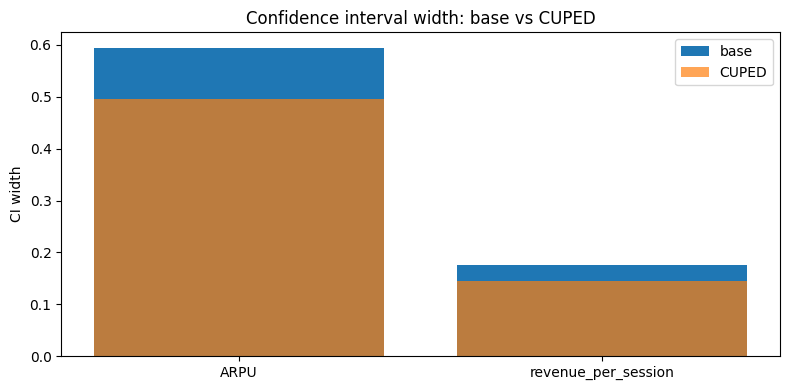

In [24]:
plt.figure(figsize=(8,4))
plt.bar(summary_ci["metric"], summary_ci["ci_width_base"], label="base")
plt.bar(summary_ci["metric"], summary_ci["ci_width_cuped"], label="CUPED", alpha=0.7)
plt.ylabel("CI width")
plt.title("Confidence interval width: base vs CUPED")
plt.legend()
plt.tight_layout()
plt.show()

## 6) Empirical power: base vs CUPED
We estimate empirical power for a fixed sample size by repeating simulations.

To keep runtime reasonable in hosted notebooks, start with:

- N_ITER = 500
- no bootstrap inside this loop

In [25]:
def arpu_test_base_and_cuped(df: pd.DataFrame, alpha: float = ALPHA):
    c, t = split_groups(df)

    y_c = arpu_vector(c); y_t = arpu_vector(t)
    x_c = arpu_covariate(c); x_t = arpu_covariate(t)

    base = welch_ttest_effect(y_c, y_t, alpha=alpha)

    cup_c, cup_t = cuped_ab_adjust(y_c, x_c, y_t, x_t)
    adj = welch_ttest_effect(cup_c.y_adj, cup_t.y_adj, alpha=alpha)

    return base["p_value"], adj["p_value"]


def ratio_linearized_base_and_cuped(df: pd.DataFrame, alpha: float = ALPHA, seed: int = 0):
    c, t = split_groups(df)

    R0_post = ratio_point(c)
    R0_pre = float(c["revenue_pre"].sum() / c["sessions_pre"].sum())

    z_c = linearized_ratio_vector(c, R0=R0_post)
    z_t = linearized_ratio_vector(t, R0=R0_post)

    zpre_c = linearized_ratio_covariate(c, R0_pre=R0_pre)
    zpre_t = linearized_ratio_covariate(t, R0_pre=R0_pre)

    base = welch_ttest_effect(z_c, z_t, alpha=alpha)

    cup_z_c, cup_z_t = cuped_ab_crossfit_adjust(z_c, zpre_c, z_t, zpre_t, seed=seed)
    adj = welch_ttest_effect(cup_z_c.y_adj, cup_z_t.y_adj, alpha=alpha)

    return base["p_value"], adj["p_value"]


def empirical_power(cfg: SyntheticB2CConfig, n_iter: int, alpha: float, seed0: int):
    rej = {"arpu_base": 0, "arpu_cuped": 0, "ratio_base": 0, "ratio_cuped": 0}
    for i in range(n_iter):
        cfg_i = SyntheticB2CConfig(**{**cfg.__dict__, "seed": seed0 + i})
        df_i = generate_user_level_data(cfg_i)

        p_arpu_base, p_arpu_cuped = arpu_test_base_and_cuped(df_i, alpha=alpha)
        p_ratio_base, p_ratio_cuped = ratio_linearized_base_and_cuped(df_i, alpha=alpha, seed=seed0 + i)

        rej["arpu_base"] += (p_arpu_base < alpha)
        rej["arpu_cuped"] += (p_arpu_cuped < alpha)
        rej["ratio_base"] += (p_ratio_base < alpha)
        rej["ratio_cuped"] += (p_ratio_cuped < alpha)

    for k in rej:
        rej[k] = rej[k] / n_iter

    return rej


N_ITER = 500

cfg_effect = SyntheticB2CConfig(
    n_users=60_000,
    seed=10,
    effect_type="mixed",
    lift_sessions=0.03,
    lift_rev_per_session=0.03,
    include_binary=False,
)

cfg_null = SyntheticB2CConfig(
    n_users=60_000,
    seed=999,
    effect_type="none",
    lift_sessions=0.0,
    lift_rev_per_session=0.0,
    include_binary=False,
)

power_eff = empirical_power(cfg_effect, n_iter=N_ITER, alpha=ALPHA, seed0=3000)
type1_eff = empirical_power(cfg_null, n_iter=N_ITER, alpha=ALPHA, seed0=4000)

pd.DataFrame([
    {"case": "power (effect)", **power_eff},
    {"case": "type I error (null)", **type1_eff},
])

,case,arpu_base,arpu_cuped,ratio_base,ratio_cuped
0,power (effect),0.192,0.222,0.146,0.192
1,type I error (null),0.040,0.046,0.038,0.054


## Interpretation (CUPED for ratio metrics)

After switching to a cross-fitted CUPED adjustment (2-fold sample splitting), the ratio + CUPED test becomes well calibrated under the null:
- Type I error: 0.054 at α = 0.05 (N=500), which is within Monte Carlo noise.

The empirical power of `ratio_cuped` decreased relative to the non-cross-fitted version. This is expected:
the earlier power gain was partially driven by inflated Type I error (liberal p-values). Cross-fitting removes this “double-dipping” effect and yields a fair comparison.

Conclusion:
- Use cross-fitted CUPED for ratio metrics to maintain Type I error control.
- Interpret power only for methods with correct calibration.

## Results summary
Typical pattern:

- CUPED improves sensitivity for ARPU when revenue_pre is correlated with revenue.
- For ratio metrics, applying CUPED on linearized values often provides additional gains.
- Under the null, rejection rates should remain close to alpha.